# Generate a Pitch
 - Given the current pitcher, game state, num pitches thrown, opposing batter characteristics, and pitcher characteristics
 - What will the next pitch look like?
## Answers 2 questions:
 - Next pitch type to be thrown?
 - What are the characteristics of the pitch (speed, release pos, zone, etc.)?
 - Will be used as input to the batter
## Potential Difficulties:
 - How do you quantify the change in pitch type distribution based on opposing batters statistics?
 - How do you factor the correlation between pitch characteristics like release pos, etc. to generate realistic pithces?
 - How do you adjust factors based on the opposing batter's zone?
 - How do you adjust based on pitch sequencing?
## TODO:
 - Write script to get features (formatted with labels in torch)
 - Hyperparameter optimization
 - Figure out how to solve small sample..

In [45]:

np.set_printoptions(suppress=True)

In [20]:
'''
To generate the characteristics of a given pitch type. For example, generate the features of a fastball. 
'''

#get query mlb db path..
import sys
import os
import itertools
#current_dir = os.path.dirname(os.path.realpath(__file__))
#parent_dir = os.path.dirname(os.path.dirname(current_dir))
#sys.path.append(parent_dir)
from src.data.data_utils import query_mlb_db
from sklearn.neighbors import KernelDensity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PITCH_CHARACTERISITCS = [
    'release_speed', 'release_spin_rate', 'release_extension',
    'release_pos_x', 'release_pos_y', 'release_pos_z',
    'spin_axis', 'pfx_x', 'pfx_z',
    'vx0', 'vy0', 'vz0',
    'ax', 'ay', 'az',
    'plate_x', 'plate_z'
]

def get_pitches(pitcher_id, opposing_stance, pitch_type, backtest_date=''):
    pitch_df =  query_mlb_db(f'''select 
        {', '.join(PITCH_CHARACTERISITCS)}, batter, strikes, balls
        from Statcast
        where pitcher={pitcher_id} and
        stand="{opposing_stance}" and
        pitch_type="{pitch_type}"
        and
        {' & '.join(PITCH_CHARACTERISITCS)} 
        is not null
        ''')

    return pitch_df

def fit_kde(pitcher_id, opposing_stance, pitch_type):

    pitch_df = get_pitches(pitcher_id, opposing_stance, pitch_type)
    X = pitch_df.values
    bandwidth = 0.1

    kde = KernelDensity(bandwidth=bandwidth, kernel='tophat')
    kde.fit(X, sample_weight=None)
    loglik = kde.score(X).sum()
    print(loglik)
    
    return kde

def sample_kde(kde, n):
    samples = kde.sample(n)
    sample_df = pd.DataFrame(samples, columns=PITCH_CHARACTERISITCS)
    return sample_df

def visually_inspect_kde(actual_pitches, sample_pitches, variable_pair):

    _, axes = plt.subplots(1, 2, figsize=(20, 6))  
    axes[0].scatter(actual_pitches[variable_pair[0]], actual_pitches[variable_pair[1]], label='Actual Pitch Correlation')
    axes[0].set_title('Scatter Plot for Actual Pitches')
    axes[0].set_xlabel(variable_pair[0])
    axes[0].set_ylabel(variable_pair[1])
    axes[0].legend()
    axes[1].scatter(sample_pitches[variable_pair[0]], sample_pitches[variable_pair[1]], label='Sample Pitch Correlation')
    axes[1].set_title('Scatter Plot for Sample Pitches')
    axes[1].set_xlabel(variable_pair[0])
    axes[1].set_ylabel(variable_pair[1])
    axes[1].legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':

    kukuchi = 579328
    jones = 683003

    pitcher = kukuchi

    actual_pitches = get_pitches(pitcher, 'R', 'FF')
    kde = fit_kde(pitcher, 'R', 'FF')
    kde_sample = sample_kde(kde, len(actual_pitches))

    #for combo in itertools.combinations(PITCH_CHARACTERISITCS, 2):
        #col1, col2 = combo
        #visually_inspect_kde(actual_pitches, kde_sample, (col1, col2))
    for col in PITCH_CHARACTERISITCS:
        visually_inspect_kde(actual_pitches, kde_sample, ('plate_x', col))



169739.69057063755


ValueError: Shape of passed values is (4101, 20), indices imply (4101, 17)

In [304]:
kukuchi = 579328
jones = 683003

pitcher = jones

all_pitches = get_pitches(pitcher,'L','FF')
all_pitches

,release_speed,release_spin_rate,release_extension,release_pos_x,release_pos_y,release_pos_z,spin_axis,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,plate_x,plate_z,batter,strikes,balls
0,96.7,2487,6.7,-1.63,53.79,5.47,221,-0.66,1.28,7.966959,-140.598396,-3.560417,-10.583175,32.853061,-14.532250,0.78,3.15,691718,0,0
1,95.8,2415,7.0,-1.42,53.48,5.65,212,-0.56,1.40,4.659671,-139.313171,-6.414642,-8.310392,32.340443,-12.736631,-0.16,2.31,683737,0,1
2,95.8,2469,7.0,-1.50,53.49,5.58,207,-0.44,1.35,7.974973,-139.322762,-4.903851,-7.568611,31.017810,-13.625916,1.10,2.78,683737,0,0
3,96.8,2467,6.8,-1.42,53.72,5.53,219,-0.80,1.35,3.694973,-140.815664,-5.213778,-11.464620,33.636246,-13.284207,-0.73,2.65,664023,2,0
4,96.5,2577,6.6,-1.68,53.85,5.47,219,-0.73,1.48,5.780517,-140.467184,-2.556503,-11.030377,33.355192,-12.211926,-0.15,3.69,643565,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,98.8,2489,6.7,-1.45,53.75,5.58,219,-0.50,1.28,5.000404,-143.843625,-3.458406,-8.061207,32.177234,-13.817661,-0.06,3.43,677800,2,3
195,99.2,2379,6.7,-1.42,53.85,5.58,221,-0.46,1.28,5.963640,-144.362199,-5.223345,-7.689265,31.114779,-13.245559,0.35,2.80,677800,2,3
196,97.4,2494,6.7,-1.53,53.79,5.62,209,-0.34,1.36,3.609259,-141.802826,-4.411867,-5.346850,31.850523,-13.035875,-0.49,3.10,677800,1,1
197,96.8,2469,6.8,-1.52,53.74,5.59,214,-0.15,1.41,4.346740,-140.803952,-6.536629,-3.027574,32.935330,-12.090102,-0.03,2.28,677800,0,1


In [305]:
sz_cluster_df = query_mlb_db('select * from BatterStrikezoneCluster')

In [222]:
sz_df = query_mlb_db('select batter, round(avg(sz_bot),3) as sz_bot, round(avg(sz_top),3) as sz_top from Statcast where sz_top is not null and sz_bot is not null group by batter')

In [223]:
sz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   batter  3129 non-null   int64  
 1   sz_bot  3129 non-null   float64
 2   sz_top  3129 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 73.5 KB


In [224]:
sz_df

,batter,sz_bot,sz_top
0,112526,1.544,3.438
1,134181,1.593,3.490
2,136860,1.650,3.546
3,150029,1.744,3.780
4,276520,1.628,3.566
...,...,...,...
3124,814307,1.570,3.360
3125,814431,1.620,3.210
3126,815694,1.620,3.210
3127,815842,1.651,3.356


In [291]:
df = pd.merge(all_pitches, sz_df, on='batter', how='left').drop(['batter'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_speed      1109 non-null   float64
 1   release_spin_rate  1109 non-null   int64  
 2   release_extension  1109 non-null   float64
 3   release_pos_x      1109 non-null   float64
 4   release_pos_y      1109 non-null   float64
 5   release_pos_z      1109 non-null   float64
 6   spin_axis          1109 non-null   int64  
 7   pfx_x              1109 non-null   float64
 8   pfx_z              1109 non-null   float64
 9   vx0                1109 non-null   float64
 10  vy0                1109 non-null   float64
 11  vz0                1109 non-null   float64
 12  ax                 1109 non-null   float64
 13  ay                 1109 non-null   float64
 14  az                 1109 non-null   float64
 15  plate_x            1109 non-null   float64
 16  plate_z            1109 

In [292]:
df[df['sz_top'] > 3.8].head()


,release_speed,release_spin_rate,release_extension,release_pos_x,release_pos_y,release_pos_z,spin_axis,pfx_x,pfx_z,vx0,...,vz0,ax,ay,az,plate_x,plate_z,strikes,balls,sz_bot,sz_top


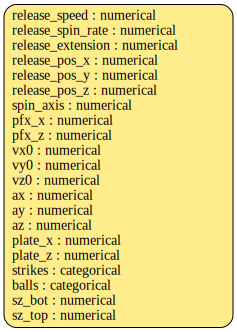

In [293]:
import sdv
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
metadata.visualize(
    show_table_details='full',
    output_filepath=None
)

In [294]:
metadata.validate_data(data=df)
metadata.get_column_names(sdtype='unknown')

[]

In [295]:
from sdv.single_table import GaussianCopulaSynthesizer

# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata,
                                       enforce_rounding=True,
                                       enforce_min_max_values=True,
                                       default_distribution='gaussian_kde')

# Step 2: Train the synthesizer
synthesizer.fit(df)

/home/reece/miniconda3/envs/mlb/lib/python3.12/site-packages/sdv/single_table/base.py:82: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [296]:
# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=500)
synthetic_data

,release_speed,release_spin_rate,release_extension,release_pos_x,release_pos_y,release_pos_z,spin_axis,pfx_x,pfx_z,vx0,...,vz0,ax,ay,az,plate_x,plate_z,strikes,balls,sz_bot,sz_top
0,94.9,2362,6.9,2.16,53.57,5.26,133,0.83,1.57,-6.037865,...,-6.622843,12.090663,34.901206,-10.985120,0.45,1.88,0,2,1.659,3.459
1,95.5,2338,7.1,2.15,53.47,5.82,146,0.51,1.54,-6.001100,...,-8.871541,7.701474,30.051740,-10.527524,0.35,1.55,0,0,1.377,3.032
2,94.5,2272,6.8,2.11,53.72,5.92,163,0.65,1.49,-6.402742,...,-9.581623,9.716372,30.625191,-11.105837,0.04,1.32,1,0,1.586,3.360
3,96.7,2401,7.1,1.64,53.37,5.38,128,0.86,1.63,-6.950041,...,-6.993164,12.854187,36.509898,-9.581398,-0.22,1.97,0,1,1.640,3.513
4,91.4,2135,6.4,1.89,54.11,5.82,155,0.40,1.31,-4.920230,...,-6.317748,5.772576,29.202388,-15.170412,0.14,2.06,2,2,1.539,3.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,95.8,2056,7.2,2.47,53.35,5.07,128,0.73,1.11,-10.023492,...,-6.618439,11.686436,29.577392,-16.360110,-0.75,1.45,2,0,1.450,3.193
496,95.0,2381,6.8,2.62,53.72,5.88,153,0.21,1.37,-7.899501,...,-2.957415,4.474867,28.768906,-14.106743,-0.07,3.72,1,2,1.524,3.389
497,94.9,2373,7.1,2.51,53.33,5.13,131,0.86,1.29,-7.886709,...,-5.807784,12.928448,32.893075,-14.541220,0.38,1.92,0,1,1.608,3.468
498,93.0,1939,6.7,2.28,53.81,5.65,140,0.67,1.42,-5.472054,...,-7.433977,9.293419,28.514487,-13.110117,0.71,1.74,0,3,1.524,3.188


In [280]:
from sdv.sampling import Condition
game_state_dict = {'strikes':0, 'balls':0, 'sz_bot':1.843, 'sz_top':3.941}
#'strikes':1, 'balls':1, 
pitch_given_game_state = Condition(
    num_rows=50,
    column_values=game_state
)

synthetic_data = synthesizer.sample_from_conditions(
    conditions=[pitch_given_game_state]
    #output_file_path='synthetic_simulated_scenario.csv'
)
synthetic_data.head()

Sampling conditions: 100%|████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.87it/s]


,release_speed,release_spin_rate,release_extension,release_pos_x,release_pos_y,release_pos_z,spin_axis,pfx_x,pfx_z,vx0,...,vz0,ax,ay,az,plate_x,plate_z,strikes,balls,sz_bot,sz_top
0,94.0,2001,6.8,2.58,53.66,5.44,136,0.75,1.12,-7.087978,...,-4.829283,10.768853,31.936425,-17.455531,0.43,2.42,0,0,1.843,3.941
1,95.6,2424,7.1,2.56,53.37,5.13,129,0.93,1.39,-9.893511,...,-0.871852,14.116478,32.268364,-14.122145,-0.33,3.88,0,0,1.843,3.941
2,94.8,2151,6.8,2.61,53.68,5.53,140,0.59,1.16,-6.797487,...,-3.007339,8.704761,25.187165,-17.054881,0.44,3.32,0,0,1.843,3.941
3,96.4,2264,7.1,2.43,53.39,5.06,122,1.10,1.45,-8.764545,...,-5.111992,16.486828,36.384553,-12.002360,0.03,2.28,0,0,1.843,3.941
4,94.3,2179,6.7,2.24,53.75,5.61,136,1.16,1.24,-6.576600,...,-7.673508,16.183155,26.547768,-14.744999,0.68,1.61,0,0,1.843,3.941


In [268]:
#real_data = df[] 
#'sz_bot':1.843142
#'sz_top':3.940592
game_state_dict = {'strikes':0, 'balls':0, 'sz_bot':1.843, 'sz_top':3.941}

real_data = df[(df['sz_bot']==game_state_dict['sz_bot']) &
                (df['sz_top'] == game_state_dict['sz_top']) &
                (df['strikes'] == game_state_dict['strikes']) &
                (df['balls']==game_state_dict['balls'])]
real_data.head()

,release_speed,release_spin_rate,release_extension,release_pos_x,release_pos_y,release_pos_z,spin_axis,pfx_x,pfx_z,vx0,...,vz0,ax,ay,az,plate_x,plate_z,strikes,balls,sz_bot,sz_top
168,92.4,1774,6.4,2.15,54.08,5.86,142,0.63,0.82,-6.989591,...,-3.229377,9.046777,24.636217,-21.675953,-0.05,3.05,0,0,1.843,3.941
1427,97.4,2294,6.7,2.57,53.76,5.33,132,0.93,1.19,-7.357605,...,-0.803186,14.213241,31.940501,-16.126493,0.65,3.99,0,0,1.843,3.941
1450,94.8,2309,6.7,2.39,53.75,5.41,131,0.98,1.52,-11.031229,...,-3.928392,15.006372,33.302976,-12.254198,-0.97,3.02,0,0,1.843,3.941
1462,94.2,2123,6.6,2.14,53.86,5.62,133,1.31,1.25,-8.081707,...,-6.567382,18.284100,29.470498,-15.140910,0.16,1.97,0,0,1.843,3.941
2301,94.7,2327,6.8,1.96,53.66,5.41,138,1.02,1.51,-5.835382,...,-3.712492,14.303171,34.723030,-12.386086,0.62,3.10,0,0,1.843,3.941


In [275]:
print(synthetic_data.max(), real_data.max())

release_speed          98.400000
release_spin_rate    2581.000000
release_extension       7.500000
release_pos_x           2.990000
release_pos_y          54.500000
release_pos_z           6.190000
spin_axis             201.000000
pfx_x                   1.430000
pfx_z                   1.850000
vx0                     1.018047
vy0                  -128.634967
vz0                     2.007307
ax                     20.893533
ay                     39.246811
az                     -6.636684
plate_x                 2.710000
plate_z                 5.140000
strikes                 2.000000
balls                   3.000000
sz_bot                  1.860000
sz_top                  3.990000
dtype: float64 release_speed          97.400000
release_spin_rate    2360.000000
release_extension       7.300000
release_pos_x           2.720000
release_pos_y          54.080000
release_pos_z           5.860000
spin_axis             146.000000
pfx_x                   1.360000
pfx_z                   1.57

In [298]:

quality_report = evaluate_quality(df, synthetic_data, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████| 21/21 [00:00<00:00, 592.65it/s]|
Column Shapes Score: 95.17%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████| 210/210 [00:01<00:00, 193.36it/s]|
Column Pair Trends Score: 95.51%

Overall Score (Average): 95.34%



In [303]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='release_speed'
)
fig.show()

In [174]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
import plotly.io as pio
import time

# 1. perform basic validity checks
diagnostic = run_diagnostic(df, synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(df, synthetic_data, metadata)

# 3. plot the data
for col in real_data.columns:
    print(col)
    fig = get_column_plot(
        real_data=df,
        synthetic_data=synthetic_data,
        metadata=metadata,
        column_name=col
    )
    pio.show(fig)
    time.sleep(0.1)

Generating report ...

(1/2) Evaluating Data Validity: |██████████████████████████████████████████████████| 21/21 [00:00<00:00, 1477.93it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |████████████████████████████████████████████████████| 1/1 [00:00<00:00, 707.54it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████| 21/21 [00:00<00:00, 442.31it/s]|
Column Shapes Score: 97.26%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████| 210/210 [00:01<00:00, 175.64it/s]|
Column Pair Trends Score: 95.22%

Overall Score (Average): 96.24%

release_speed


release_spin_rate


release_extension


release_pos_x


release_pos_y


release_pos_z


spin_axis


pfx_x


pfx_z


vx0


vy0


vz0


ax


ay


az


plate_x


plate_z


strikes


balls


sz_bot


sz_top
